<p><strong><span style="font-size: 20px; color: rgb(124, 112, 107);">Background</span></strong></p>
<p><span style="color: rgb(0, 0, 0);">The data obtained from Kaggle. Propertyid, location_id, page_url property_type, price, location, city, province_name, latitude, longitude, baths, area, pupose, bedrooms, date_added,agency, and agent are all included in the dataset. This data spans the periods 2018-8 to 2019-8.</span></p>

Datasets is downloaded from here: https://www.kaggle.com/huzzefakhan/zameencom-property-data-pakistan

In [267]:
import math
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20,10)

import missingno as msno
from autoviz.AutoViz_Class import AutoViz_Class
import dtale

import folium
from folium.plugins import MarkerCluster

from scipy import stats

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [268]:
#Check the shape of the dataset after loading it.
df = pd.read_csv('dataset.csv')
df.shape

(191393, 24)

In [269]:
df.sample(5)

,property_id,location_id,page_url,property_type,price,price_bin,location,city,province_name,locality,...,area_marla,area_sqft,purpose,bedrooms,date_added,year,month,day,agency,agent
144101,17157838,528,https://www.zameen.com/Property/lahore_jail_ro...,Flat,45000,High,Jail Road,Lahore,Punjab,"Jail Road, Lahore, Punjab",...,2.7,735.08,For Rent,2,07-10-2019,2019,7,10,NaN,NaN
51735,15320772,8888,https://www.zameen.com/Property/gulistan_e_jau...,House,15500000,Medium,Gulistan-e-Jauhar,Karachi,Sindh,"Gulistan-e-Jauhar, Karachi, Sindh",...,4.8,1306.80,For Sale,5,07-01-2019,2019,7,1,Roomi Associates,Azam Khursheed
187861,17435678,1503,https://www.zameen.com/Property/askari_askari_...,Flat,40000,High,Askari,Lahore,Punjab,"Askari, Lahore, Punjab",...,10.0,2722.51,For Rent,3,07-24-2019,2019,7,24,Sukhera Brothers,M. Umar Sukhera
21994,12918433,3826,https://www.zameen.com/Property/gulberg_3_gulb...,House,50000000,Very High,Gulberg,Lahore,Punjab,"Gulberg, Lahore, Punjab",...,24.0,6534.02,For Sale,0,11-05-2018,2018,11,5,NaN,NaN
187304,17432682,1788,https://www.zameen.com/Property/bahria_town_se...,House,26000000,High,Bahria Town,Lahore,Punjab,"Bahria Town, Lahore, Punjab",...,10.0,2722.51,For Sale,5,07-22-2019,2019,7,22,HMA Properties,Waseem Subhani And Mubashar


### EDA

In [270]:
df1 = df.drop(['property_id', 'location_id', 'page_url', 'area', 'area_marla', 'locality', 'agency', 'agent'], axis='columns')
df1.shape

(191393, 16)

In [271]:
#Remove the day and save it in the date_added column.
df1['date_added'] = pd.to_datetime(df1['date_added'])
df1 = df1.reset_index()
df1['date_added'] = df1['date_added'].apply(lambda x: x.strftime('%Y-%m'))

In [272]:
#This function removes outliers from one or more columns.
def remove_outlier(df, column_lst):
    df_in = df
    for col in column_lst:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_in = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_in

In [273]:
#Boxplots from one or more columns are shown using this function.
def show_graphs(df, lst, title=""):
    if len(lst) > 1:
        fig, axs = plt.subplots(1, len(lst), figsize=(16, 5))
        for i in range(0, len(lst)):
            axs[i].boxplot(df[lst[i]])
            axs[i].set_title(lst[i])
        fig.suptitle(title)
    else:
        fig, axs = plt.subplots(figsize=(16, 8))
        axs.boxplot(df[lst[0]])
        axs.set_title(lst[0])
        fig.suptitle(title)

<AxesSubplot:>

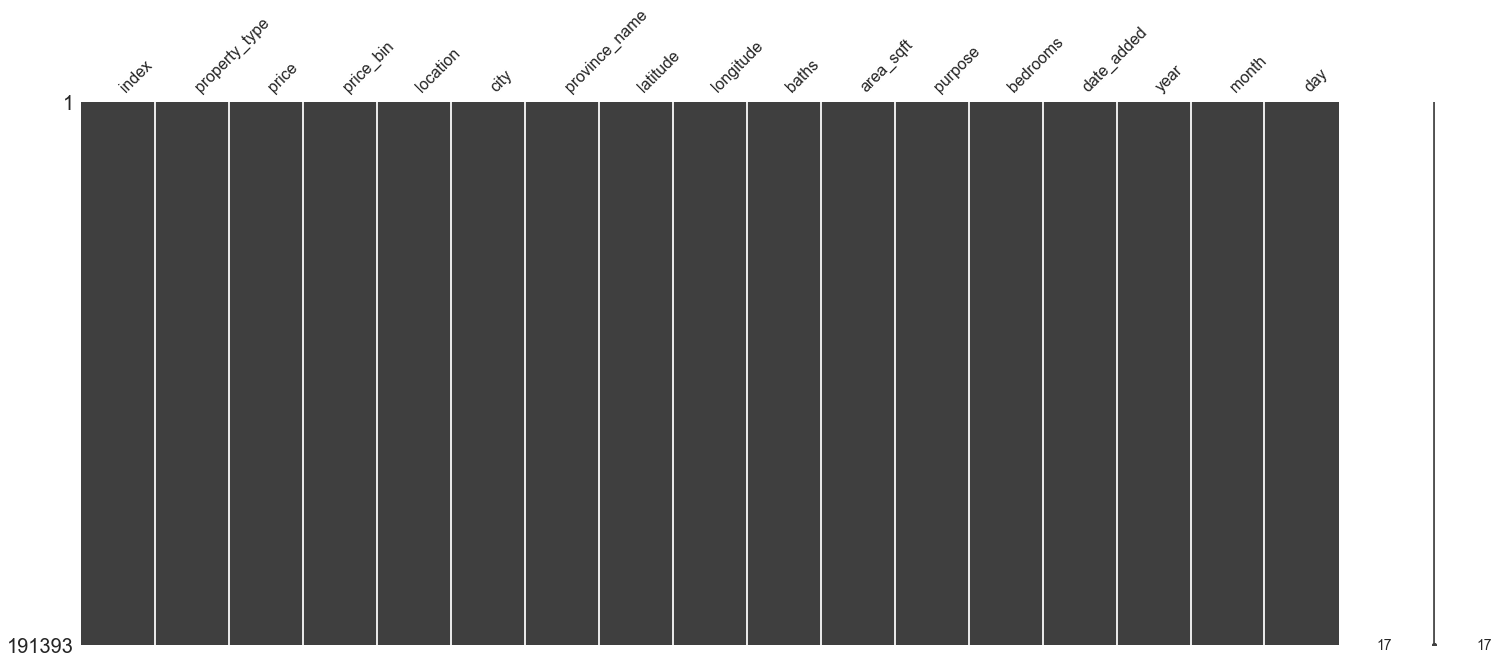

In [274]:
#Examine the values that are missing.
msno.matrix(df1)

In [275]:
df1.sample(5)

,index,property_type,price,price_bin,location,city,province_name,latitude,longitude,baths,area_sqft,purpose,bedrooms,date_added,year,month,day
11302,11302,House,9000000,Low,Malir,Karachi,Sindh,24.868605,67.179165,7,1306.80,For Sale,6,2019-07,2019,7,17
60051,60051,House,130000,High,Bahria Town,Lahore,Punjab,31.374195,74.191482,6,5445.02,For Rent,5,2019-06,2019,6,24
90115,90115,House,14000000,Medium,Bahria Town Karachi,Karachi,Sindh,25.058062,67.306626,3,2178.01,For Sale,3,2019-07,2019,7,2
165575,165575,Upper Portion,80000,Very High,I-8,Islamabad,Islamabad Capital,33.662782,73.077793,0,5445.02,For Rent,4,2019-07,2019,7,15
159862,159862,House,4400000,Low,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,4,2178.01,For Sale,3,2019-07,2019,7,13


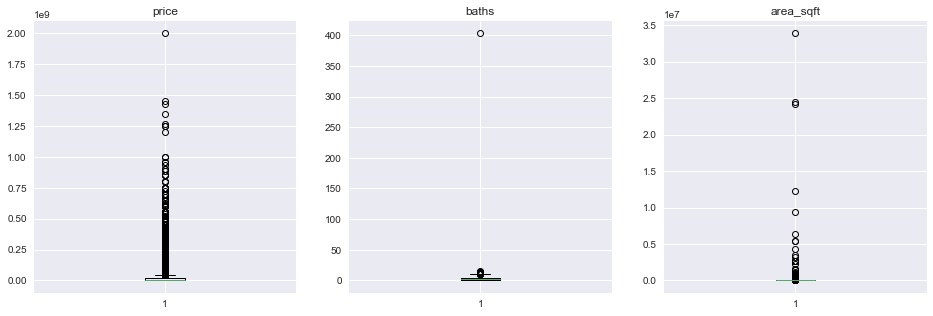

In [276]:
#Check the Outliers
show_graphs(df1,['price','baths','area_sqft'])

In [277]:
#Remove Ouliers
df2 = remove_outlier(df1, ['price','baths','area_sqft'])

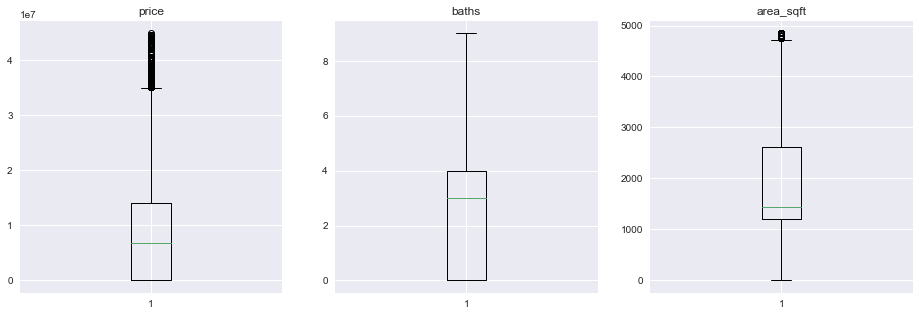

In [278]:
#Check the Outliers
show_graphs(df2,['price','baths','area_sqft'])

In [279]:
#Add a column called price_per_sqft that contains price divided area_sqft values.
df3 = df2.copy()
df3['price_per_sqft'] = df2['price']/df2['area_sqft']

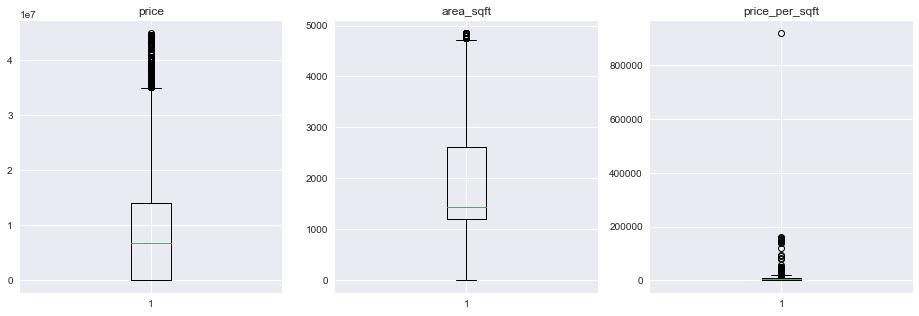

In [280]:
#Check the Outliers
show_graphs(df3,['price', 'area_sqft', 'price_per_sqft'])

In [281]:
#Remove Outliers
df4 = remove_outlier(df3, ['price_per_sqft'])

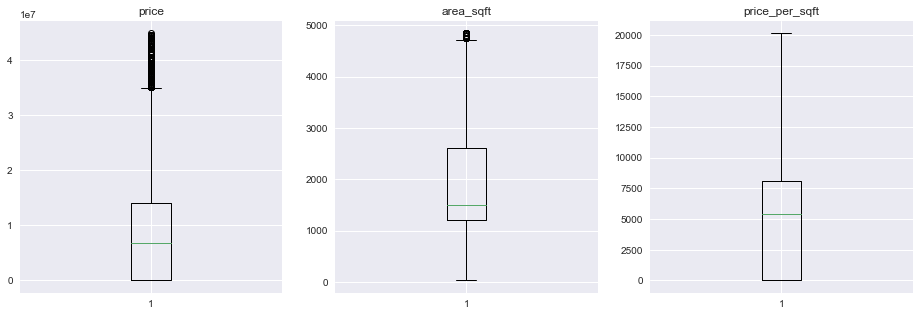

In [282]:
#Check the Outliers
show_graphs(df4,['price', 'area_sqft', 'price_per_sqft'])

In [283]:
df4.to_csv("df4.csv",index=False)

Shape of your Data Set: (148654, 18)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  4
    Number of Integer-Categorical Columns =  5
    Number of String-Categorical Columns =  5
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    18 Predictors classified...
        This does not include the Target column(s)
        2 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 10


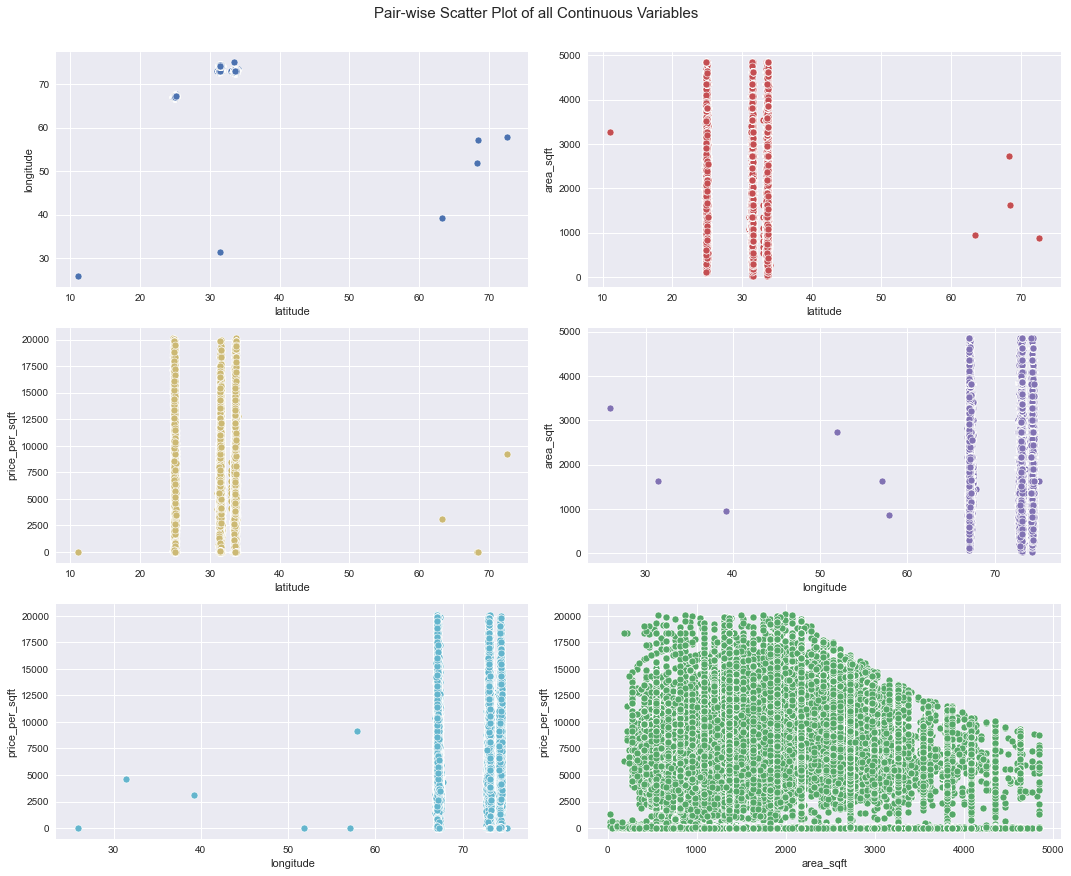

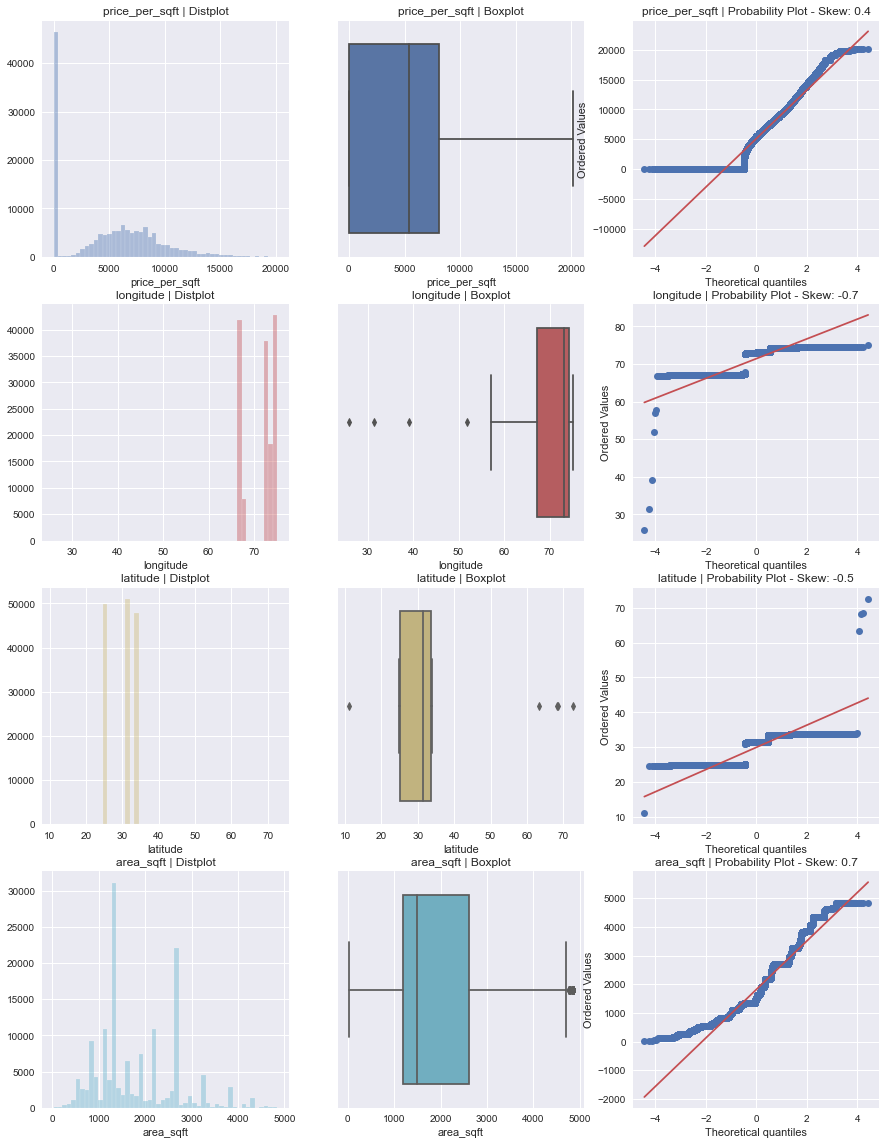

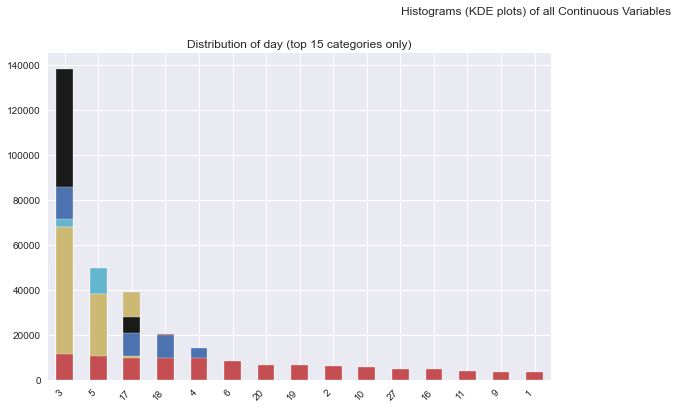

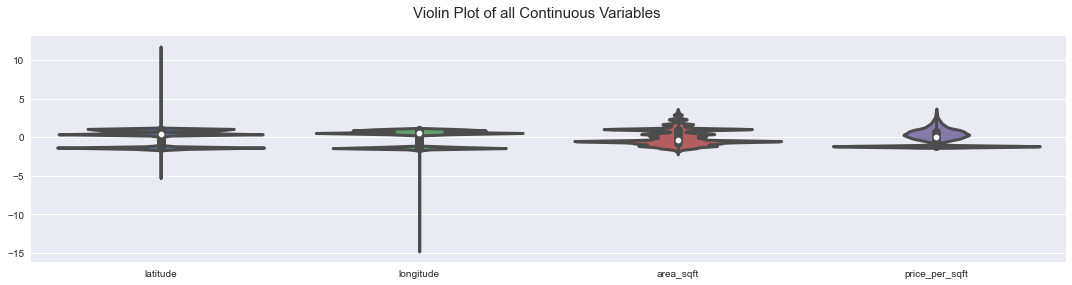

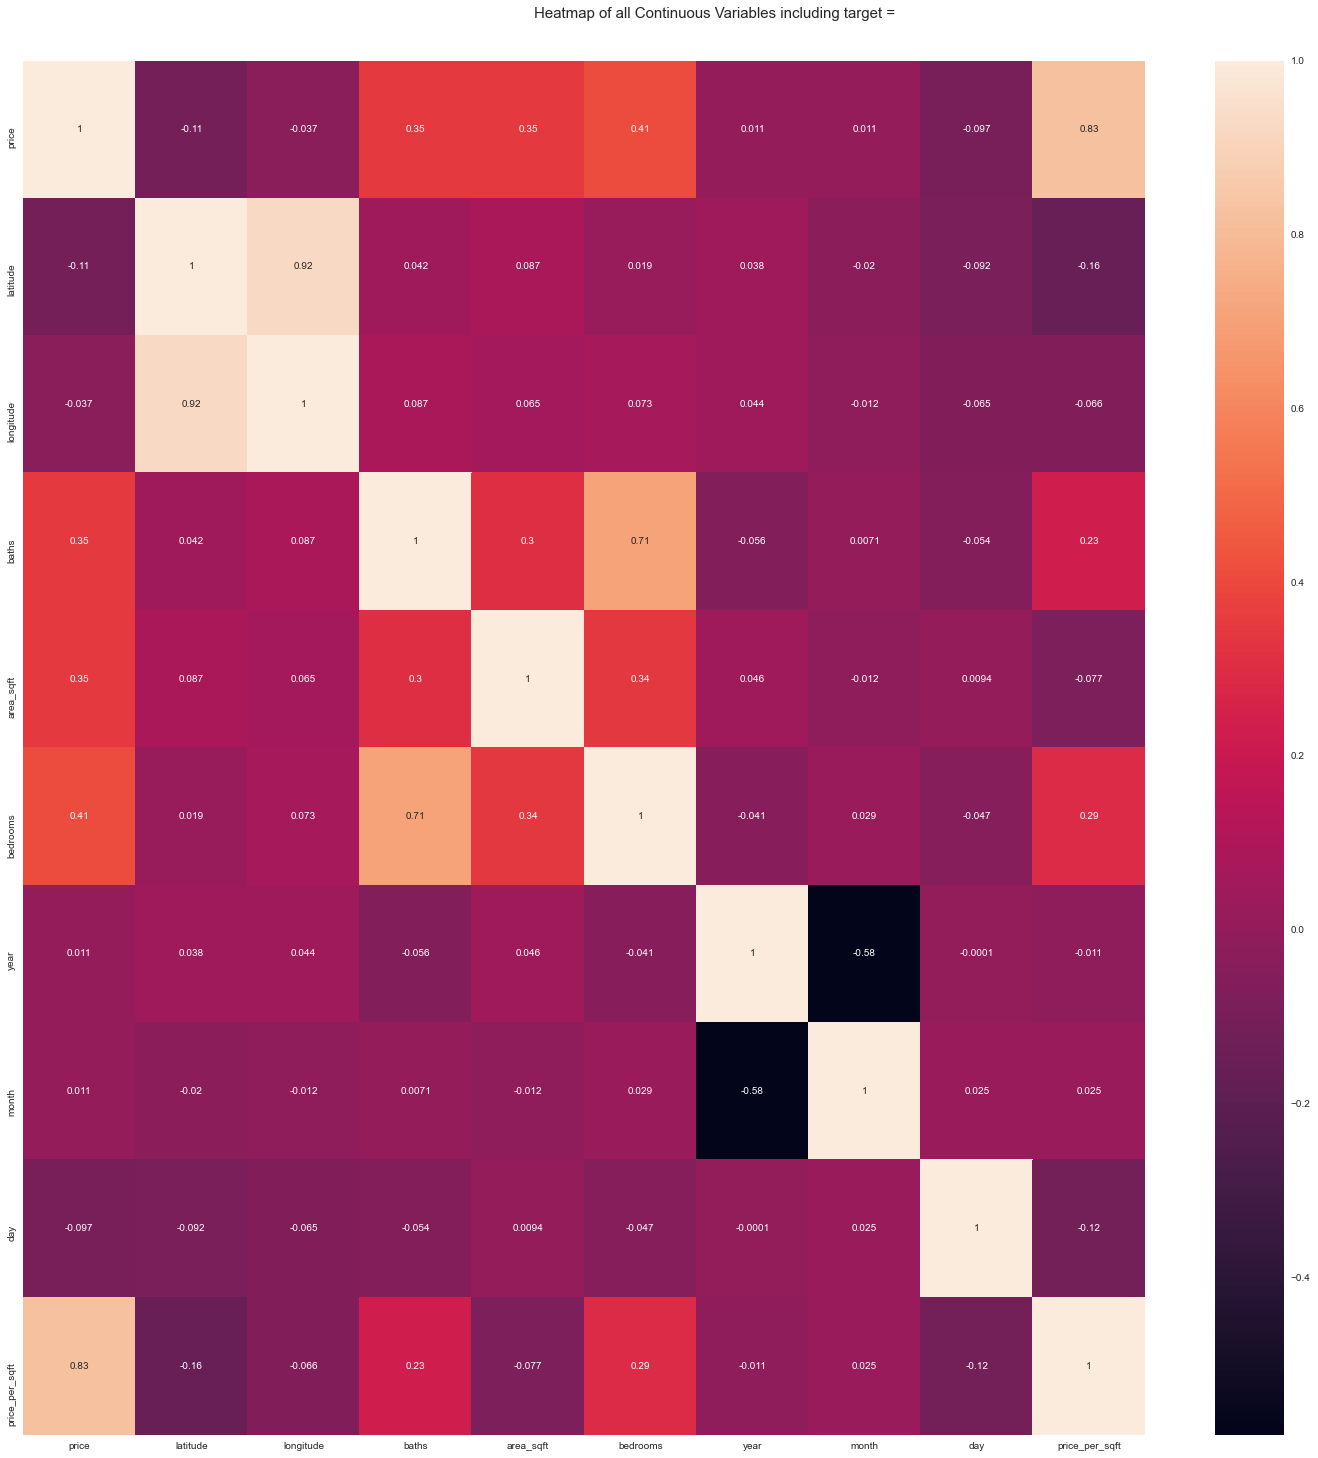

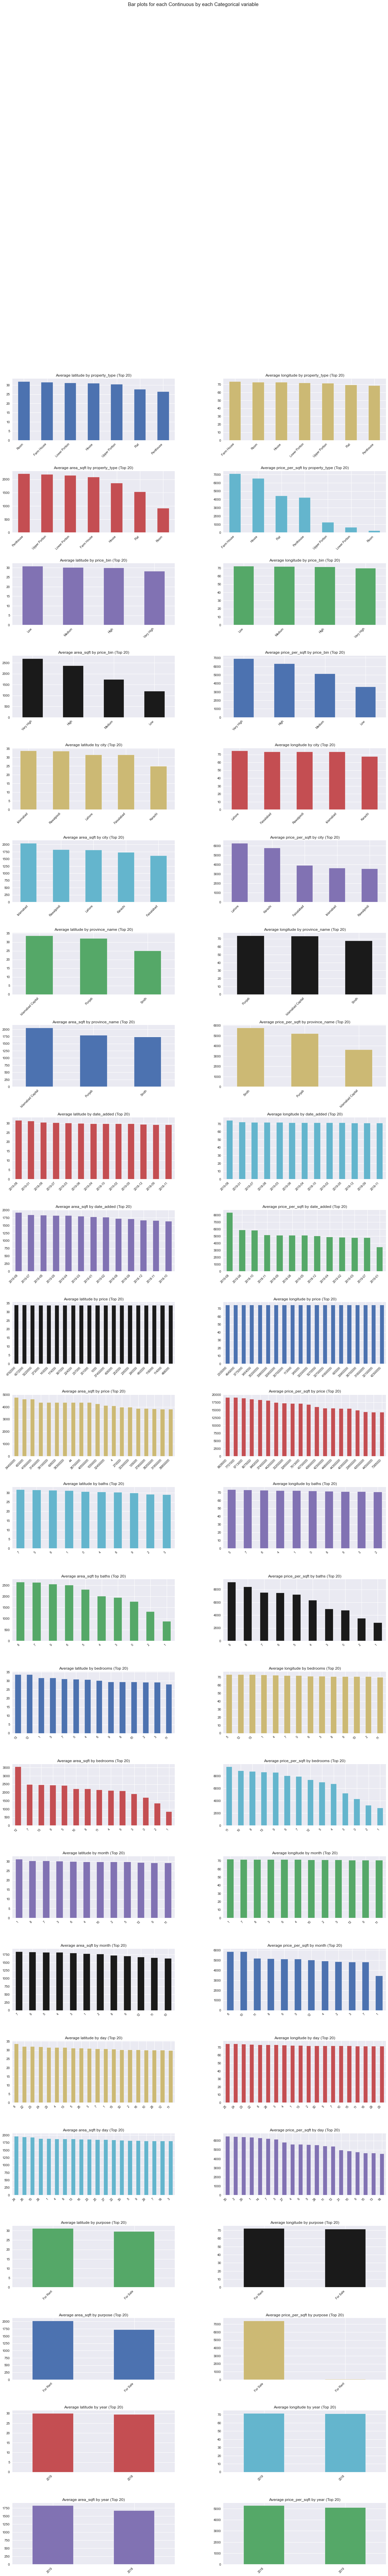

Time to run AutoViz (in seconds) = 20.830

 ###################### VISUALIZATION Completed ########################


In [284]:
#EDA using Autoviz
autoviz = AutoViz_Class().AutoViz('df4.csv')

In [285]:
#EDA using dtale Lib
dtale.show(df4)

In [286]:
# Remove outliers
index = df4[(df4['baths']==0) & (df4['bedrooms']>1)].index
df5 = df4.drop(index) 

index = df5[(df5['property_type']=='Room') & ((df5['baths']>1) | (df5['bedrooms']>1))].index
df6 = df5.drop(index)

index = df6[(df6['bedrooms']==0)].index
df7 = df6.drop(index)

index = df7[((df7['bedrooms'])+3)<df7['baths']].index
df8 = df7.drop(index)

In [287]:
#Remove outliers from Square Feet, Bedrooms and bathrooms
def remove_outliers(df,p_type,area,bedrooms,baths):
    sqft = np.sort(df[area].unique())
    for sq in sqft:
        rooms = int(((0.5*sq)/171)+2)
        df.loc[(df[p_type]!='Room') & (df[area]==sq) & (df[bedrooms]>rooms), [bedrooms]] = rooms
        df.loc[(df[p_type]!='Room') & (df[area]==sq) & (df[baths]>(rooms+2)), [baths]] = rooms+2

remove_outliers(df8,'property_type','area_sqft','bedrooms','baths')

In [288]:
#The available data includes both selling and renting items, but I'm only interested in selling items because buyers are aware of the true value of homes, flats, and other properties based on location and rooms.
#That's why i drop the Rental Rows and save into df9 
index = df8[df8['purpose']=='For Rent'].index
df9 = df8.drop(index)

#Since there are so many outliers in the price_bin column, it should be removed.
df10 = df9.drop(['price_bin'], axis='columns')

#Add a price_bin column based on this criterion.
df10['price_bin'] = 'Low'
df10.loc[(df10['price']>2500000) & (df10['price']<=5000000),['price_bin']] = 'Medium'
df10.loc[(df10['price']>5000000) & (df10['price']<=10000000),['price_bin']] = 'High'
df10.loc[(df10['price']>10000000),['price_bin']] = 'Very High'

#Drop below 50 thousand price rows
df11 = df10[df10['price']>50000]

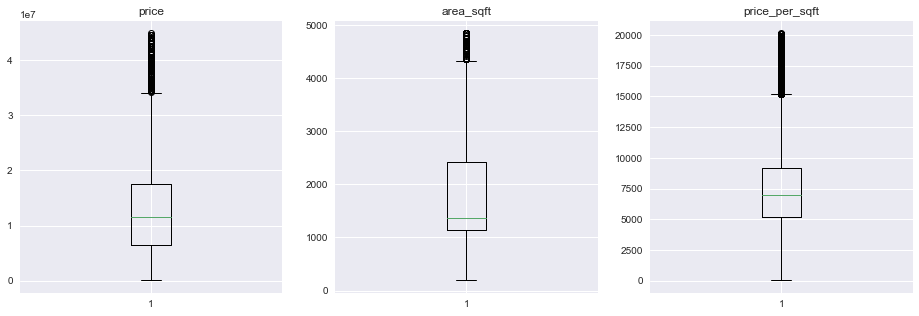

In [289]:
#Check the Outliers
show_graphs(df11,['price', 'area_sqft', 'price_per_sqft'])

#These columns are now better at predicting unseen data by using machine learning algorithms.

### Visualization

##### By date, sell a house, a farm house, a flat, and other things.

In [290]:
def selling_by_date(df):
    df = df.sort_values(by="date_added")
    date = df['date_added'].unique()
    p_type_dict = {}
    grouped_p_type = df.groupby('property_type')
    for pt in grouped_p_type.groups.keys():
        lst = []
        for dt in date:
            df_dt = df[(df["date_added"] == dt) & (df['property_type']==pt)]
            df_dt_sum = len(df_dt)

            if df_dt_sum > 0:
                lst.append(df_dt_sum)
            else:
                lst.append(0)
        p_type_dict[pt] = lst
    
    return date, p_type_dict

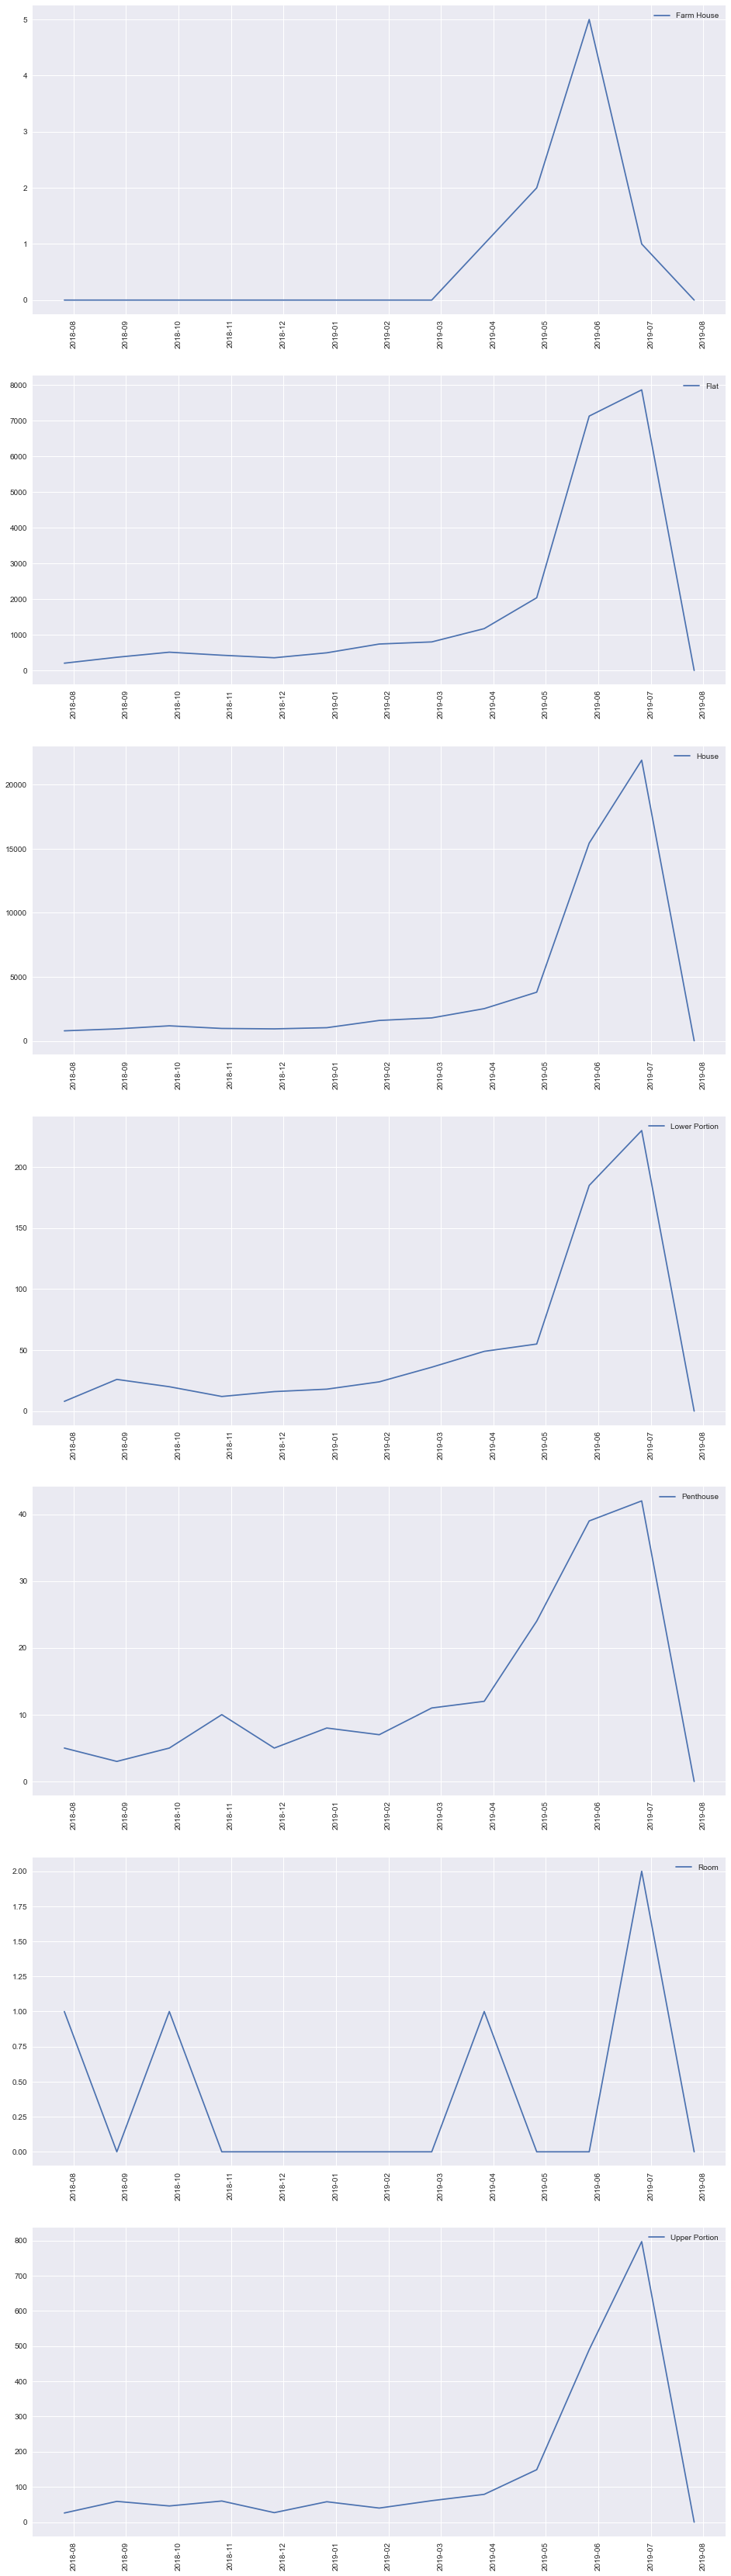

In [291]:
labels, p_type = selling_by_date(df11)

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(len(p_type), 1, figsize=(16, 60),)
count = 0 
for pt in p_type.keys():
    ax[count].plot(x - width/2, p_type.get(pt), label = pt)
    ax[count].set_xticks(x)
    ax[count].set_xticklabels(labels, rotation=90)
    ax[count].legend()
    count+=1

    
plt.show()

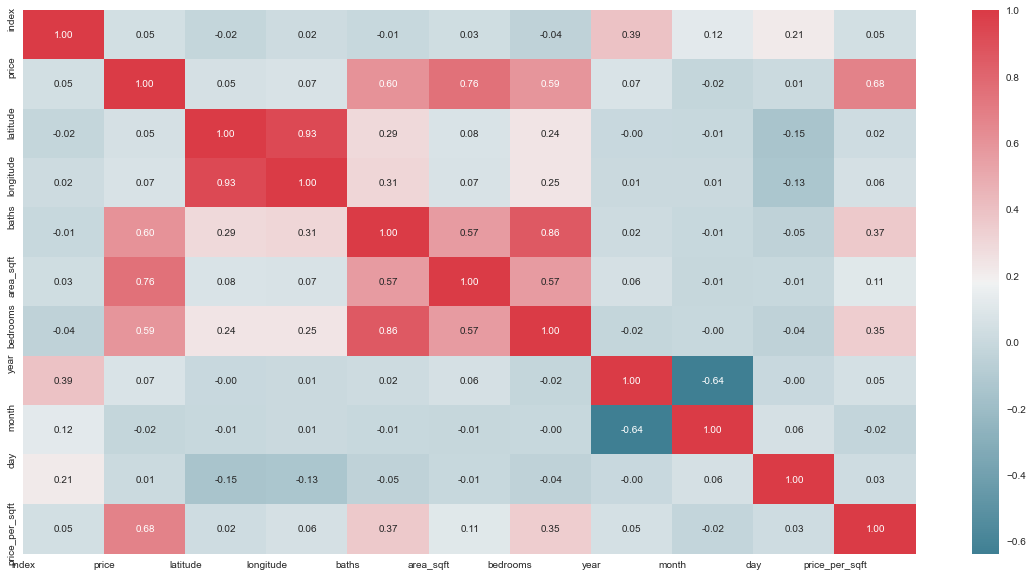

In [292]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(20, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()
    
heatMap(df11)

### Use one Hot Encoding

In [293]:
dummy1 = pd.get_dummies(df11.property_type)
dummy2 = pd.get_dummies(df11.price_bin)
dummy3 = pd.get_dummies(df11.location)
dummy4 = pd.get_dummies(df11.city)
dummy5 = pd.get_dummies(df11.province_name)

df12 = pd.concat([df11.drop(['property_type','price_bin','location','latitude','longitude','city','province_name','purpose','date_added','year','month','day'], axis='columns'),dummy1,dummy2,dummy3,dummy4,dummy5],axis='columns')
df12.sample(5)

,index,price,baths,area_sqft,bedrooms,price_per_sqft,Farm House,Flat,House,Lower Portion,...,Zulfiqar Colony,circular road,Faisalabad,Islamabad,Karachi,Lahore,Rawalpindi,Islamabad Capital,Punjab,Sindh
33883,33883,14000000,5,1306.80,4,10713.192531,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
155650,155650,25000000,7,2722.51,6,9182.702727,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
39884,39884,4500000,2,980.10,2,4591.368228,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
57496,57496,4000000,4,544.50,3,7346.189164,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
35909,35909,8500000,2,1197.90,2,7095.750897,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


### Build a Machine Learning Model

In [294]:
X = df12.drop(['price'], axis='columns')
y = df12.price

In [295]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [296]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X, y)

DecisionTreeRegressor(random_state=0)

### Test the Model

In [297]:
def predict_price(location,baths,area_sqft,bedrooms):    
    loc_index = np.where(X.columns==location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = baths
    x[1] = area_sqft
    x[2] = bedrooms
    if loc_index >= 0:
        x[loc_index] = 1
    return regressor.predict([x])[0]

In [298]:
#First argument is location
#Second argument is bathrooms
#Third argument is area of square feet
#Last and fourth argument is bedrooms
predict_price('Bahria Town Karachi',5, 2778, 5)

400000.0

<h1 style='color:purple' align='center'>Thank you so much for taking the time to look at my notebook. Please upvote if you like my Notebook.<h1/>